Project Proposal

Title:


Introduction:

Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
Clearly state the question you will try to answer with your project
Identify and describe the dataset that will be used to answer the question


Preliminary exploratory data analysis:

Demonstrate that the dataset can be read from the web into R 
Clean and wrangle your data into a tidy format
Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

Methods:

Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results

Expected outcomes and significance:

What do you expect to find?
What impact could such findings have?
What future questions could this lead to?

In [43]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [44]:
attrition_data<-read.csv ("https://raw.githubusercontent.com/wenshanli1231/DSCI-Group-Project/main/Employee-Attrition.csv")
attrition_data

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,⋯,2,80,1,6,0,3,6,2,0,3
49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,⋯,4,80,0,17,3,2,9,6,0,8
34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,⋯,1,80,0,6,3,4,4,3,1,2


In [45]:
attrition_data <- attrition_data |>
    select( Attrition, HourlyRate, YearsAtCompany)

attrition_data <- attrition_data |>
        mutate(Attrition = as_factor(Attrition))

In [46]:
attrition_split <- initial_split(attrition_data, prop = 0.75, strata = Attrition)
attrition_train <- training(attrition_split)
attrition_test <- testing(attrition_split) 

In [50]:
set.seed(10)

attrition_recipe <- recipe(Attrition~ HourlyRate + YearsAtCompany, data = attrition_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
    
attrition_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
       set_engine("kknn") |>
       set_mode("classification")

attrition_fit <- workflow() |>
       add_recipe(attrition_recipe) |>
       add_model(attrition_spec) |>
       fit(data = attrition_train)


ERROR: [1m[33mError[39m in `check_installs()`:[22m
[33m![39m This engine requires some package installs: 'kknn'


**Summarized training data in 1 table code**


In [52]:
attrition_table <- attrition_train |>
        group_by(Attrition) |>
        summarize( 
            mean_HourlyRate = mean(HourlyRate), 
            mean_YearsAtCompany = mean(YearsAtCompany), 
            count = n(), 
            count_blanks = sum(is.na(Attrition))
        )

attrition_table

Attrition,mean_HourlyRate,mean_YearsAtCompany,count,count_blanks
<fct>,<dbl>,<dbl>,<int>,<int>
Yes,65.72881,4.881356,177,0
No,66.57143,7.480519,924,0


**Visualization of training data code**

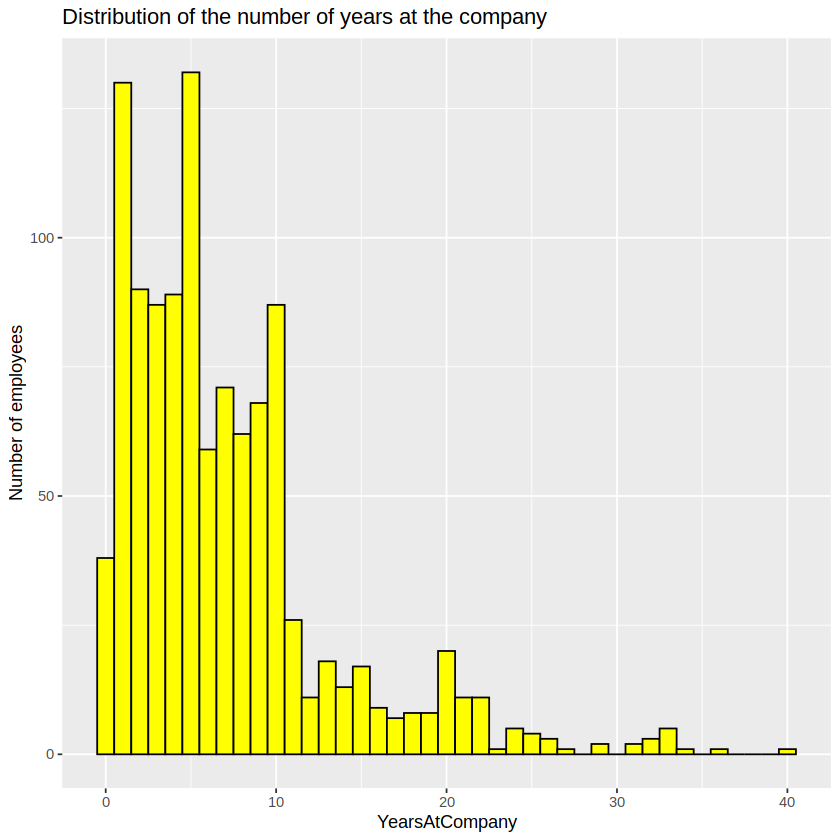

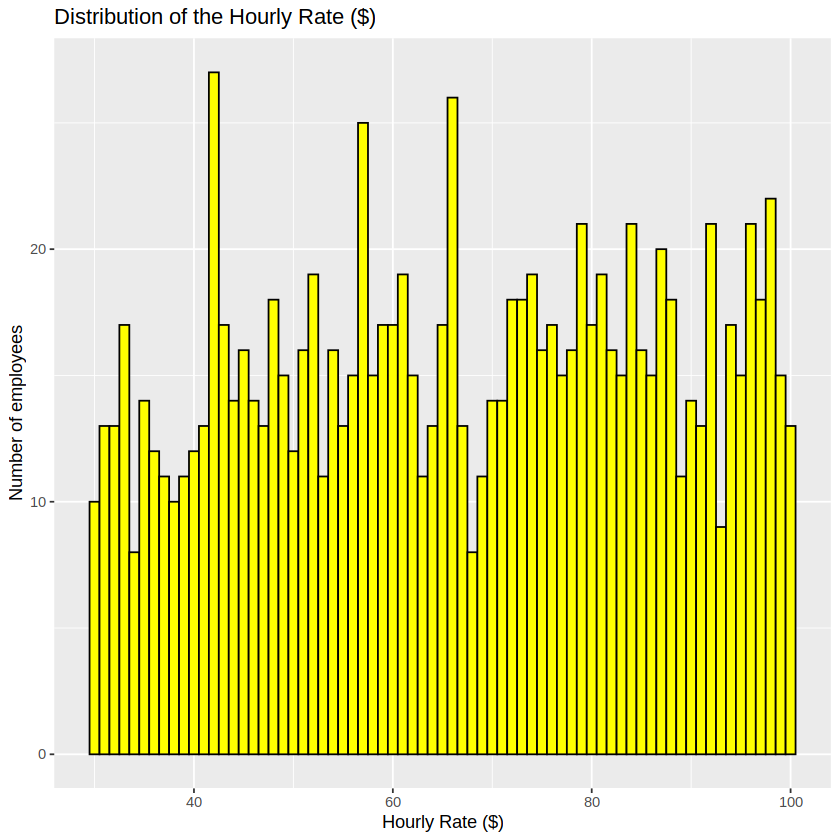

In [74]:
attrition_plot_years_at_company <- ggplot(attrition_train, aes(x = YearsAtCompany)) + 
            geom_histogram(binwidth = 1, fill = "yellow", color = "black") +
            ylab("Number of employees") +  #Standarized or unstandardized
            labs(title = "Distribution of the number of years at the company") 
            

attrition_plot_years_at_company


attrition_plot_hourly_rate <- ggplot(attrition_train, aes(x = HourlyRate)) + 
            geom_histogram(binwidth = 1, fill = "yellow", color = "black") +
            xlab("Hourly Rate ($)") +
            ylab("Number of employees") +  #Standarized or unstandardized
            labs(title = "Distribution of the Hourly Rate ($)")

attrition_plot_hourly_rate

In [62]:
attrition_proportions <- attrition_train |>
                      group_by(Attrition) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(attrition_train))

attrition_proportions

attrition_proportions_train <- attrition_train |>
                      group_by(Attrition) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(attrition_train))

attrition_proportions_train



Attrition,n,percent
<fct>,<int>,<dbl>
Yes,177,16.07629
No,924,83.92371


Attrition,n,percent
<fct>,<int>,<dbl>
Yes,177,16.07629
No,924,83.92371
